C:\Users\hp\AppData\Local\Temp\ipykernel_30668\346242860.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../data/raw/BrentOilPrices.csv", parse_dates=["Date"])


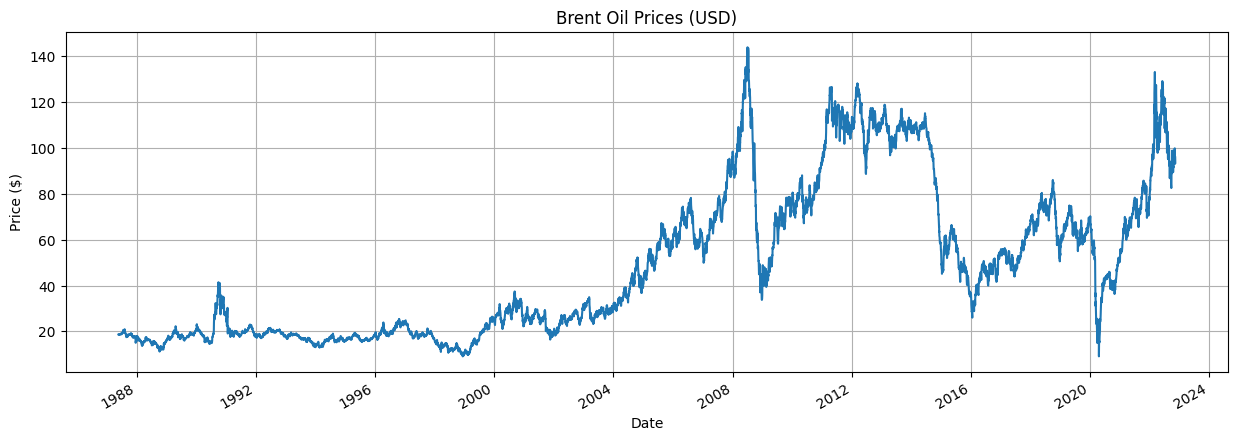

In [1]:
# Brent Oil Price Change Point Analysis
# -------------------------------------
# This notebook performs change point detection on Brent oil price data 
# using Bayesian inference with PyMC3.

# 1. Load and visualize data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../data/raw/BrentOilPrices.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Plot raw prices
df['Price'].plot(figsize=(15, 5), title='Brent Oil Prices (USD)')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.grid(True)
plt.show()


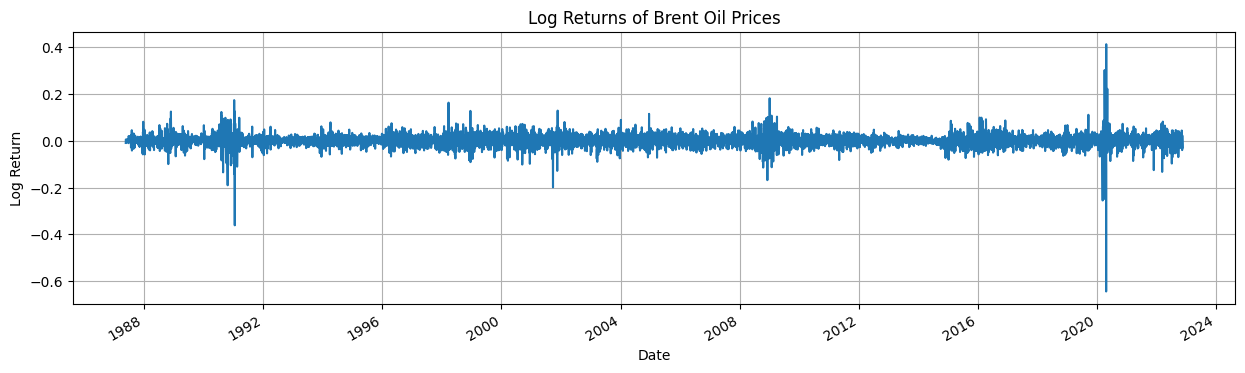

In [2]:
# Calculate log returns
df["LogReturn"] = np.log(df["Price"] / df["Price"].shift(1))
df.dropna(inplace=True)

# Plot log returns
df["LogReturn"].plot(figsize=(15, 4), title="Log Returns of Brent Oil Prices")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()


In [3]:
import pymc as pm
import arviz as az

# Use a smaller subset for speed
log_returns = df["LogReturn"].values[:1000]
n = len(log_returns)
idx = np.arange(n)

with pm.Model() as model:
    # Change point
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)

    # Means and stds
    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)

    # Switch logic
    mu = pm.math.switch(idx < tau, mu1, mu2)
    sigma = pm.math.switch(idx < tau, sigma1, sigma2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=log_returns)

    # Sample
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=42)


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3380 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


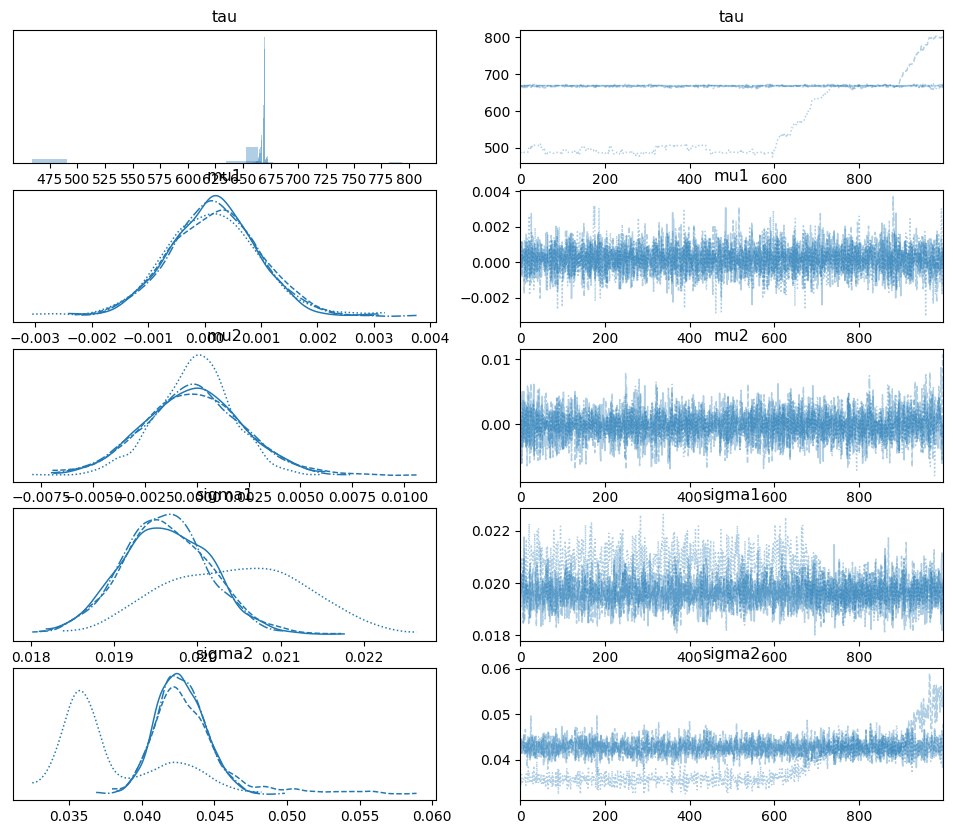

In [4]:
# Plot trace
az.plot_trace(trace, var_names=["tau", "mu1", "mu2", "sigma1", "sigma2"])
plt.show()


In [5]:
# Extract tau value (most probable change point)
most_prob_tau = int(trace.posterior["tau"].mean().values)
change_date = df.iloc[most_prob_tau].name

print(f"Most probable change point at index {most_prob_tau}")
print(f"Estimated date of change: {change_date.date()}")


Most probable change point at index 641
Estimated date of change: 1989-11-21
